## 2단계: 피처 엔지니어링(Feature Engineering)
피처 엔지니어링은 데이터에 대한 도메인 지식을 사용해서 머신러닝 알고리즘이 보다 잘 동작하도록 만들어주는 피처 혹은 열을 만드는 과정을 뜻합니다. 그리고 피처 엔지니어링은 머신러닝 애플리케이션의 기초가 되지만 어렵고 비용이 많이 드는 작업입니다. 

이번 피처 엔지니어링 노트북은 **"데이터 입수"** 노트북에서 S3에 저장한 데이터 셋을 사용합니다 그리고 각각의 데이터를 하나의 데이터 셋으로 합쳐 장비의 상태를 확인할 때 사용할 것입니다. 이 노트북을 통해 여러가지 피처 엔지니어링과 라벨링 기법을 배워보고 예지정비 머신러닝 솔루션을 위한 데이터 셋을 생성할 것입니다. 

In [1]:
!pip3 install plotnine

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
# 필요한 라이브러리 셋팅하기
import time
import os
import glob
import boto3

import pandas as pd

import matplotlib.pyplot as plt
from plotnine import *

import datetime
from pyspark.sql.functions import to_date

import pyspark.sql.functions as F
from pyspark.sql.functions import col, unix_timestamp, round, date_format
from pyspark.sql.functions import datediff
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()



In [15]:
# S3 스토리지 관련 정보
bucket = 'jdkimexample'
prefix = 'pred-maintenance-artifacts'
basedataurl = "data/EquipData/"
s3 = boto3.client('s3')
s3_bucket_resource = boto3.resource('s3').Bucket(bucket)

# 각 데이터 파일에 대한 정보
MACH_DATA = 'PdM_machines.csv'
MAINT_DATA = 'PdM_maint.csv'
ERROR_DATA = 'PdM_errors.csv'
TELEMETRY_DATA = 'PdM_telemetry.csv'
FAILURE_DATA = 'PdM_failures.csv'


## 데이터 세트 가져오기
S3로부터 데이터 세트를 가져오겠습니다

In [62]:
# 장비 데이터 세트
machines_object = s3.get_object(Bucket=bucket,Key=basedataurl+MACH_DATA)
machines = pd.read_csv(machines_object['Body'])
machines = spark.createDataFrame(machines)

machines.limit(5).toPandas().head(5)

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [63]:
# 에러 데이터 세트
errors_object = s3.get_object(Bucket=bucket,Key=basedataurl+ERROR_DATA)
errors = pd.read_csv(errors_object['Body'])
errors = spark.createDataFrame(errors)

errors.limit(5).toPandas().head(5)

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [64]:
# 점검 데이터 세트
maint_object = s3.get_object(Bucket=bucket,Key=basedataurl+MAINT_DATA)
maint = pd.read_csv(maint_object['Body'])
maint = spark.createDataFrame(maint)

maint.limit(5).toPandas().head(5)

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [65]:
# 시계열 데이터 세트
telemetry_object = s3.get_object(Bucket=bucket,Key=basedataurl+TELEMETRY_DATA)
telemetry = pd.read_csv(telemetry_object['Body'])
telemetry = spark.createDataFrame(telemetry)

telemetry.limit(5).toPandas().head(5)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [66]:
# 결함 데이터 세트
failure_object = s3.get_object(Bucket=bucket,Key=basedataurl+FAILURE_DATA)
failure = pd.read_csv(failure_object['Body'])
failure = spark.createDataFrame(failure)

failure.limit(5).toPandas().head(5)

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


예지정비는 타임스탬프를 가진 과거 데이터를 가지고 현재 부품의 상태와 근시일 내에 결함이 날 확률을 예측하는 것입니다. 이는 시계열 데이터를 포함하는 분류 방법으로 생각해볼 수 있습니다. 왜냐하면 정해진 시간의 간격만큼(예를 들면 7일) 동안에 결함이 발생할지 안할지를 판단하는 문제로 생각해볼 수 있기 때문입니다. 

### 시간 지연 피처 (Time Lag features)
시계열 데이터로부터 피처를 생성하는 방법에는 여러가지가 있습니다. 우선 데이터가 수집된 기간을 각 레코드가 통일될 수 있는 시간 단위로 나누는 것부터 시작합니다. 이때 레코드가 수집되는 기간은 초, 분, 시간, 일 또는 월 단위가 될 수 있습니다. 이러한 단위는 사용 사례의 도메인에 따라 달라질 수 있습니다.

시간 단위가 데이터가 수집된 빈도와 같을 필요는 없습니다. 예를 들어, 만약 온도가 10초마다 수집되었을 때 값이 천천히 변하는 경우에 시간 단위를 10초로 한다면 데이터 수는 많아지지만 그 데이터로 부터 의미있는 정보를 얻을 것입니다. 그래서 더 나은 방법은 더 긴 시간 단위(분, 시간)로 온도의 평균 값을 구해서 이를 사용하는 것입니다. 

시간 단위를 정했으면, 성능 저하를 예측하기 위해 시간 경과에 따른 측정 값에서 패턴을 찾고 이를 부품이 결함이 날 가능성과 연결시킬 수 있습니다. 성능 변화를 확인하기 위해 이전에 측정된 값에서 시간 지연을 활용하여 새로운 피처를 만드는 방법을 활용할 수 있습니다. 아래 그림에서 W는 지연 시간의 간격을 나타내는 값입니다. 
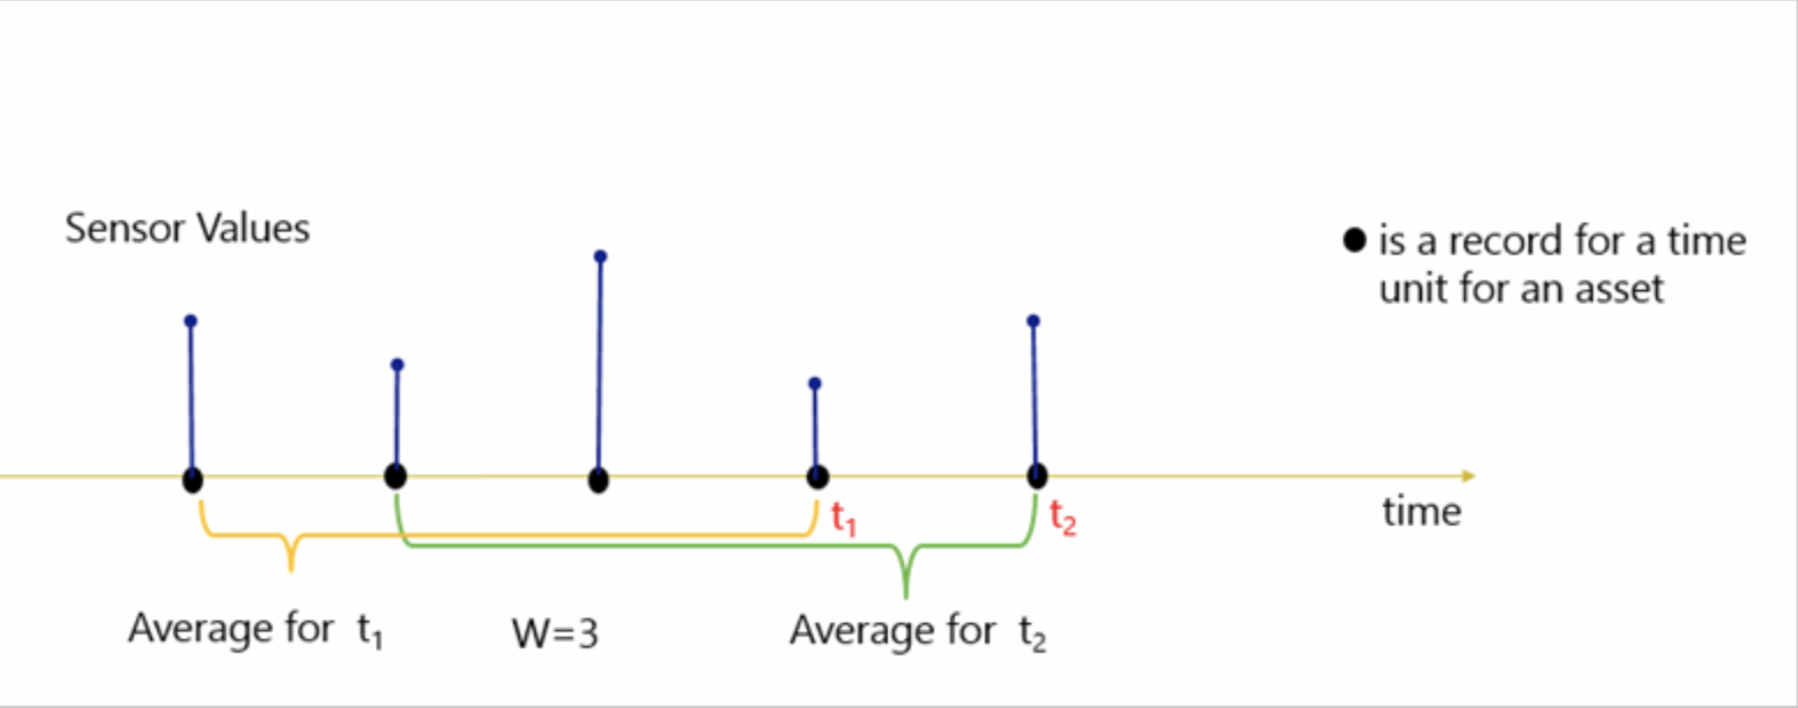

### 시계열 피처 (Telemetry features)
시계열 측정 데이터에는 100개의 장비에 대해서 8,761,000 시간의 측정 값이 있습니다. 여기서 센서 측정값을 12시간 간격으로 측정된 값을 평균내서 집계함으로써 모델 성능을 향상시킬 수 있습니다. 이렇게 함으로써 731,000개의 측정값으로 줄일 수도 있습니다 그리고 그 결과 레이블 지정과 모델링을 할 때 필요한 리소스 및 시간을 줄여줍니다. 

In [103]:
tel_mean = telemetry

# 시계열 데이터에서 관심이 있는 피처
rolling_features = ['volt', 'rotate', 'pressure', 'vibration']

# n 시간 = n * 3600 초
time_val = 12 * 3600

# dt_truncated는 현재 데이터 세트에서 "datetime"이라는 열을 찾습니다. 
dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))

In [105]:
# 시간 간격을 12시간, 24시간, 36시간 중에서 선택할 수 있습니다.
lags = [12, 24, 36]

# 데이터 정렬하기
for lag_n in lags:
    wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-lag_n, 0)
    for col_name in rolling_features:
        tel_mean = tel_mean.withColumn(col_name+'_rollingmean_'+str(lag_n),
                                      F.avg(col(col_name)).over(wSpec))
        tel_mean = tel_mean.withColumn(col_name+'_rollingstd_'+str(lag_n),
                                      F.stddev(col(col_name)).over(wSpec))

# 지연 값 계산하기
telemetry_feat = (tel_mean.withColumn("dt_truncated", dt_truncated)
                  .drop('volt', 'rotate', 'pressure', 'vibration')
                  .fillna(0)
                  .groupBy("machineID","dt_truncated")
                  .agg(F.mean('volt_rollingmean_12').alias('volt_rollingmean_12'),
                       F.mean('rotate_rollingmean_12').alias('rotate_rollingmean_12'), 
                       F.mean('pressure_rollingmean_12').alias('pressure_rollingmean_12'), 
                       F.mean('vibration_rollingmean_12').alias('vibration_rollingmean_12'), 
                       F.mean('volt_rollingmean_24').alias('volt_rollingmean_24'),
                       F.mean('rotate_rollingmean_24').alias('rotate_rollingmean_24'), 
                       F.mean('pressure_rollingmean_24').alias('pressure_rollingmean_24'), 
                       F.mean('vibration_rollingmean_24').alias('vibration_rollingmean_24'),
                       F.mean('volt_rollingmean_36').alias('volt_rollingmean_36'),
                       F.mean('vibration_rollingmean_36').alias('vibration_rollingmean_36'),
                       F.mean('rotate_rollingmean_36').alias('rotate_rollingmean_36'), 
                       F.mean('pressure_rollingmean_36').alias('pressure_rollingmean_36'), 
                       F.stddev('volt_rollingstd_12').alias('volt_rollingstd_12'),
                       F.stddev('rotate_rollingstd_12').alias('rotate_rollingstd_12'), 
                       F.stddev('pressure_rollingstd_12').alias('pressure_rollingstd_12'), 
                       F.stddev('vibration_rollingstd_12').alias('vibration_rollingstd_12'), 
                       F.stddev('volt_rollingstd_24').alias('volt_rollingstd_24'),
                       F.stddev('rotate_rollingstd_24').alias('rotate_rollingstd_24'), 
                       F.stddev('pressure_rollingstd_24').alias('pressure_rollingstd_24'), 
                       F.stddev('vibration_rollingstd_24').alias('vibration_rollingstd_24'),
                       F.stddev('volt_rollingstd_36').alias('volt_rollingstd_36'),
                       F.stddev('rotate_rollingstd_36').alias('rotate_rollingstd_36'), 
                       F.stddev('pressure_rollingstd_36').alias('pressure_rollingstd_36'), 
                       F.stddev('vibration_rollingstd_36').alias('vibration_rollingstd_36'), ))

print(telemetry_feat.count())
telemetry_feat.where((col("machineID") == 1)).limit(10).toPandas().head(10)

73100


,machineID,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,...,pressure_rollingstd_12,vibration_rollingstd_12,volt_rollingstd_24,rotate_rollingstd_24,pressure_rollingstd_24,vibration_rollingstd_24,volt_rollingstd_36,rotate_rollingstd_36,pressure_rollingstd_36,vibration_rollingstd_36
0,1,2015-04-02 12:00:00,170.478471,435.909512,99.752331,40.484945,170.160617,442.344746,99.035064,40.090184,...,0.308191,0.327755,1.086067,2.753280,0.747193,0.318579,0.279382,1.666786,0.151812,0.110267
1,1,2015-05-12 00:00:00,168.138220,445.532077,100.126187,41.553186,170.468817,451.173076,98.871345,41.193639,...,2.769747,0.883941,0.927353,1.180674,1.100933,0.541122,0.386050,1.022840,0.476738,0.362613
2,1,2015-07-26 12:00:00,167.443609,457.720006,100.574573,39.855291,168.106865,458.422300,101.261589,40.546170,...,1.222672,0.411915,0.807261,3.953519,0.323735,0.327569,0.505668,1.720010,0.170246,0.155935
3,1,2015-08-04 00:00:00,172.743066,454.774561,100.203734,39.391182,171.527486,457.767422,100.708625,39.403172,...,1.909033,1.263579,0.298750,1.895032,0.762826,0.486233,0.423125,1.102895,0.454150,0.180924
4,1,2015-08-23 12:00:00,165.256680,481.530207,97.620427,39.884730,166.509285,475.985592,97.444318,39.855508,...,1.786555,1.080365,0.432085,1.902104,0.317767,0.156053,0.694941,4.927032,0.502533,0.122031
5,1,2015-12-17 00:00:00,165.054093,452.480256,103.903565,39.400935,170.219678,456.383612,100.803884,41.990441,...,0.567128,0.385495,0.711238,4.473087,0.657798,0.921145,0.840776,2.293382,0.187560,0.106445
6,1,2015-02-16 12:00:00,171.097993,432.522159,104.291691,41.138682,168.412583,437.393456,102.696738,40.839696,...,2.134690,0.905948,0.858123,2.393162,0.154447,0.543675,0.249997,1.405005,0.294215,0.296511
7,1,2015-10-30 12:00:00,168.230264,459.960362,99.457341,42.175653,167.069907,460.558628,99.652174,41.684979,...,1.103530,0.327080,0.648966,3.465186,0.272595,0.184179,0.710895,1.226260,0.211267,0.073332
8,1,2015-10-31 12:00:00,170.947958,455.583036,99.728263,39.497592,171.892418,460.862557,98.874131,40.294696,...,1.033899,0.195851,0.673829,2.231873,0.451595,0.164689,0.735519,0.821759,0.307502,0.126155
9,1,2015-12-11 12:00:00,170.692755,469.543618,103.404829,41.540217,175.419453,459.438267,102.687416,41.599081,...,1.329404,0.814183,0.845151,4.356706,0.367822,0.154463,0.370159,1.910102,0.483233,0.319979


### Lookout for Equipment 훈련 데이터 생성
Lookout for Equipment는 훈련을 위해 정해진 포맷으로 데이터 세트를 구성해야합니다. 
따라서 피처 엔지니어링을 통해 만들어낸 데이터를 Lookout for Equipment가 모델을 생성하기에 적합한 형태로 바꿔서 S3에 저장해야합니다.

In [130]:
# Lookout for Equipment에 맞는 데이터 형태로 변환
telemetry_equipment = (telemetry_feat.withColumn("Timestamp", date_format(col("dt_truncated"),"yyyyMMddHHmmss"))
                       .drop("dt_truncated")
                       .orderBy('machineID',"Timestamp"))

telemetry_equipment.limit(10).toPandas().head(10)

,machineID,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,volt_rollingmean_36,...,vibration_rollingstd_12,volt_rollingstd_24,rotate_rollingstd_24,pressure_rollingstd_24,vibration_rollingstd_24,volt_rollingstd_36,rotate_rollingstd_36,pressure_rollingstd_36,vibration_rollingstd_36,Timestamp
0,1,168.230981,428.889639,102.153706,39.927856,168.230981,428.889639,102.153706,39.927856,168.230981,...,2.358561,2.252231,22.356941,4.695439,2.358561,2.252231,22.356941,4.695439,2.358561,20150101120000
1,1,168.476346,446.601319,96.316365,40.618666,167.922496,440.043412,98.534414,40.048817,167.922496,...,0.640086,1.062369,1.009163,0.357303,0.206886,1.062369,1.009163,0.357303,0.206886,20150102000000
2,1,172.469820,447.396678,97.164049,39.212348,170.473083,446.998999,96.740207,39.915507,169.854731,...,0.477803,0.800699,2.640192,0.688139,0.251879,0.242733,1.024351,0.290070,0.112618,20150102120000
3,1,167.128130,454.743644,101.793694,39.154459,169.798975,451.070161,99.478872,39.183403,169.358098,...,0.524439,0.415794,1.422670,0.499562,0.294581,0.537149,1.983341,0.253001,0.232822,20150103000000
4,1,175.144693,470.929443,97.089573,45.566071,171.136411,462.836544,99.441633,42.360265,171.580881,...,0.991288,0.358433,1.814617,0.433020,1.250188,0.254001,1.173642,0.095243,1.040118,20150103120000
5,1,169.280323,443.722253,99.130397,51.892909,172.212508,457.325848,98.109985,48.729490,170.517715,...,0.592195,0.655516,2.286646,0.576130,0.838369,0.236112,1.370452,0.400423,0.164542,20150104000000
6,1,172.930013,446.833128,104.227393,52.781847,171.105168,445.277691,101.678895,52.337378,172.451676,...,0.828315,2.003332,3.353176,0.385715,0.331839,1.514908,1.285493,0.460953,0.968673,20150104120000
7,1,173.302702,440.586352,96.800228,50.858178,173.116358,443.709740,100.513810,51.820013,171.837679,...,0.836693,1.159934,2.884223,0.566016,0.240998,0.771485,2.010108,0.320595,0.176539,20150105000000
8,1,170.844178,446.190872,102.973673,46.499854,172.073440,443.388612,99.886950,48.679016,172.358965,...,1.046681,1.740955,3.806739,0.734064,1.089854,0.328739,1.795149,0.423394,0.756817,20150105120000
9,1,173.248541,470.415999,102.542720,39.505734,172.046360,458.303436,102.758196,43.002794,172.465140,...,0.288061,1.473349,1.753062,0.205568,1.169368,1.196165,1.368957,0.266990,0.169656,20150106000000


In [140]:
prefix = 'processed'

# 처리된 데이터를 머신 ID에 따라 나눠서 저장합니다.
# 데이터가 업로드 되는데 시간이 2분 정도 걸립니다. 
# 시간 상 10개의 장비만 처리합니다. 
for i in range(1, 11):
    i_telemetry = telemetry_equipment.where((col("machineID") == i))
    i_telemetry.drop("machineID").toPandas().to_csv(f"s3://{bucket}/{prefix}/{i}_machine/{i}_machine.csv",index=False)
               

### 레이블 생성
예지 정비는 지도 학습입니다. 결함을 예측하도록 모델을 훈련하려면 결함에 대한 데이터 및 결함과 관련된 시계열 데이터가 필요하게 됩니다. 또한 모델이 결함과 정상 상태를 구분하기 위해 정상 작동 기간의 데이터도 필요하게 됩니다. 정상 상태와 결함 상태를 구분은 보통 boolean 라벨링으로 표시합니다. 

만약 정상 상태와 결함 상태를 비교하는 방식으로 접근하게 되면, 예지 정비는 결함에 대한 사전 경고를 주는 것으로 이뤄질 수 있습니다. 이를 달성하기 위해 결함이 발생하는 이벤트에 대한 이벤트 기간을 약간 수정하여 레이블을 설정합니다. 이러한 이벤트 기간은 비즈니스에 따라 달라질 수 있습니다. 장애가 발생하지 않도록 예측해야하는 이벤트 기간이 12시간인지, 아니면 24시간인지, 아니면 2주 정도는 미리 알아야하는지, 이벤트 기간을 어떻게 정하느냐에 따라 임박한 오류나 결함을 정확하게 예측하는 모델의 능력이 달라질 수 있습니다. 결함에 대한 주기가 짧으면 더 긴 이벤트 기간은 도움이 되지 않을 수 있으며 잠재적으로는 모델의 성능을 저하시킬 수 있습니다. 

결함을 결함이 일어날 징조로 변환하기 위해, 결함 이벤트에 대한 레이블을 추가하고 결함 관련 경고에 대한 이벤트 기간내 모든 데이터를 결함에 대한 레이블로 지정합니다. 그러면 예측 문제는 이러한 이벤트 기간내에서 결함이 일어날 확률을 추정하는 것이 됩니다. 

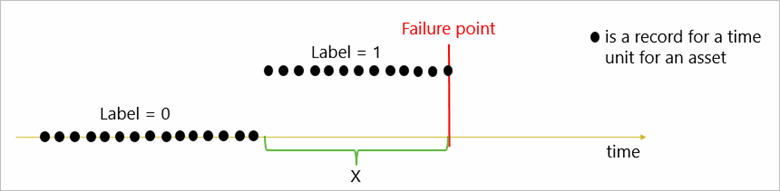

여기서는 특정 부품의 결함으로 인해 가까운 장래에 장비가 고장날 확률을 추정합니다. 목표는 각 부품의 결함(부품 1,2,3, 또는 4)로 인해 다음 7일 동안 장비가 결함이 날 확률을 계산하는 것입니다. 아래에서는 레이블 역할을 하기 위한 범주형으로 결함에 대한 피처를 생성합니다. 부품 1에 결함이 발생하기 전 24시간 내에 있는 모든 데이터는 failure="comp1"으로 표시하며 부품2, 3, 4에 대해서도 동일하게 적용합니다. 부품 결함 후 7일 이내에 있지 않은 모든 데이터는 failure="none"으료 표시합니다.

In [157]:
dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))

fail_diff = (failure.withColumn("dt_truncated", dt_truncated)
             .drop(failure.datetime))

print(fail_diff.count())
fail_diff.limit(10).toPandas().head(10)

761


,machineID,failure,dt_truncated
0,1,comp4,2015-01-05 12:00:00
1,1,comp1,2015-03-06 12:00:00
2,1,comp2,2015-04-20 12:00:00
3,1,comp4,2015-06-19 12:00:00
4,1,comp4,2015-09-02 12:00:00
5,1,comp2,2015-10-17 12:00:00
6,1,comp4,2015-12-16 12:00:00
7,2,comp1,2015-03-19 12:00:00
8,2,comp2,2015-03-19 12:00:00
9,2,comp2,2015-04-18 12:00:00


다음으로 레이블을 텍스트에서 숫자 값으로 변환합니다. 이렇게 변환함으로써 정상과 임박한 장애라는 boolean 문제에서 다중 클래스의 정상과 부품 n번의 임박한 장애라는 문제로 바뀌게 됩니다.

In [159]:
labeled_features = (telemetry_feat.join(fail_diff, 
                                    ((telemetry_feat['machineID'] == fail_diff['machineID']) 
                                     & (telemetry_feat['dt_truncated'] == fail_diff['dt_truncated'])), "left")
                    .drop(fail_diff.machineID).drop(fail_diff.dt_truncated)
                    .withColumn('failure', F.when(col('failure') == "comp1", 1.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp2", 2.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp3", 3.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp4", 4.0).otherwise(col('failure'))))

labeled_features = (labeled_features.withColumn("failure", 
                                                labeled_features.failure.cast(DoubleType()))
                    .fillna(0))

print(labeled_features.count())
labeled_features.limit(10).toPandas().head(10)

73142


,machineID,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,...,vibration_rollingstd_12,volt_rollingstd_24,rotate_rollingstd_24,pressure_rollingstd_24,vibration_rollingstd_24,volt_rollingstd_36,rotate_rollingstd_36,pressure_rollingstd_36,vibration_rollingstd_36,failure
0,1,2015-04-02 12:00:00,170.478471,435.909512,99.752331,40.484945,170.160617,442.344746,99.035064,40.090184,...,0.327755,1.086067,2.753280,0.747193,0.318579,0.279382,1.666786,0.151812,0.110267,0.0
1,1,2015-05-12 00:00:00,168.138220,445.532077,100.126187,41.553186,170.468817,451.173076,98.871345,41.193639,...,0.883941,0.927353,1.180674,1.100933,0.541122,0.386050,1.022840,0.476738,0.362613,0.0
2,1,2015-07-26 12:00:00,167.443609,457.720006,100.574573,39.855291,168.106865,458.422300,101.261589,40.546170,...,0.411915,0.807261,3.953519,0.323735,0.327569,0.505668,1.720010,0.170246,0.155935,0.0
3,1,2015-08-04 00:00:00,172.743066,454.774561,100.203734,39.391182,171.527486,457.767422,100.708625,39.403172,...,1.263579,0.298750,1.895032,0.762826,0.486233,0.423125,1.102895,0.454150,0.180924,0.0
4,1,2015-08-23 12:00:00,165.256680,481.530207,97.620427,39.884730,166.509285,475.985592,97.444318,39.855508,...,1.080365,0.432085,1.902104,0.317767,0.156053,0.694941,4.927032,0.502533,0.122031,0.0
5,1,2015-12-17 00:00:00,165.054093,452.480256,103.903565,39.400935,170.219678,456.383612,100.803884,41.990441,...,0.385495,0.711238,4.473087,0.657798,0.921145,0.840776,2.293382,0.187560,0.106445,0.0
6,2,2015-05-31 00:00:00,178.301491,477.432384,102.133424,39.619962,174.662587,460.821680,97.464361,40.686238,...,0.428865,0.334792,3.517085,0.281096,0.131425,0.236857,2.422268,0.497127,0.186134,0.0
7,2,2015-08-23 00:00:00,174.018684,449.643761,104.651429,41.236201,170.285015,446.080434,103.446676,39.896288,...,0.552345,0.535536,1.811390,1.617781,0.244479,0.302981,1.361506,0.795476,0.129738,0.0
8,2,2015-09-14 12:00:00,168.493396,452.011170,99.095607,52.152973,167.119976,456.502057,98.068539,52.322046,...,0.558005,0.503847,2.233133,0.290646,0.116113,0.480437,1.549521,0.165905,1.105396,0.0
9,3,2015-02-17 12:00:00,167.248311,442.801753,97.885906,40.236352,169.393078,449.010547,98.547768,39.569061,...,1.063008,1.113815,3.620953,0.467739,0.134391,0.843448,1.382013,0.294886,0.244927,0.0


부품 결함에 대한 데이터를 올바르게 할당했는지 확인하기 위해 피처 데이터 내에서 결함 클래스를 계산합니다.

In [160]:
# 부품 결함에 대한 빈도수를 얻습니다
df = labeled_features.select(labeled_features.failure).toPandas()
df['failure'].value_counts()

0.0    72381
2.0      259
1.0      192
4.0      179
3.0      131
Name: failure, dtype: int64

In [161]:
# 레이블을 수동으로 채우기 위한 지연 값(bfill = 7)
my_window = Window.partitionBy('machineID').orderBy(labeled_features.dt_truncated.desc())

# 7일간 과거 데이터를 생성합니다
labeled_features = (labeled_features.withColumn("prev_value1", 
                                                F.lag(labeled_features.failure).
                                                over(my_window)).fillna(0))
labeled_features = (labeled_features.withColumn("prev_value2", 
                                                F.lag(labeled_features.prev_value1).
                                                over(my_window)).fillna(0))
labeled_features = (labeled_features.withColumn("prev_value3", 
                                                F.lag(labeled_features.prev_value2).
                                                over(my_window)).fillna(0))
labeled_features = (labeled_features.withColumn("prev_value4", 
                                                F.lag(labeled_features.prev_value3).
                                                over(my_window)).fillna(0)) 
labeled_features = (labeled_features.withColumn("prev_value5", 
                                                F.lag(labeled_features.prev_value4).
                                                over(my_window)).fillna(0)) 
labeled_features = (labeled_features.withColumn("prev_value6", 
                                                F.lag(labeled_features.prev_value5).
                                                over(my_window)).fillna(0))
labeled_features = (labeled_features.withColumn("prev_value7", 
                                                F.lag(labeled_features.prev_value6).
                                                over(my_window)).fillna(0))

# 레이블 피처를 생성합니다
labeled_features = (labeled_features.withColumn('label', labeled_features.failure + 
                                                labeled_features.prev_value1 +
                                                labeled_features.prev_value2 +
                                                labeled_features.prev_value3 +
                                                labeled_features.prev_value4 +
                                                labeled_features.prev_value5 + 
                                                labeled_features.prev_value6 + 
                                                labeled_features.prev_value7))

# 레이블에 대한 범위를 0:4로 제한하고 나머지 열을 제거합니다
labeled_features = (labeled_features.withColumn('label_e', F.when(col('label') > 4, 4.0)
                                                .otherwise(col('label')))
                    .drop(labeled_features.prev_value1).drop(labeled_features.prev_value2)
                    .drop(labeled_features.prev_value3).drop(labeled_features.prev_value4)
                    .drop(labeled_features.prev_value5).drop(labeled_features.prev_value6)
                    .drop(labeled_features.prev_value7).drop(labeled_features.label))

print(labeled_features.count())
labeled_features.limit(10).toPandas().head(10)

73142


,machineID,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,...,volt_rollingstd_24,rotate_rollingstd_24,pressure_rollingstd_24,vibration_rollingstd_24,volt_rollingstd_36,rotate_rollingstd_36,pressure_rollingstd_36,vibration_rollingstd_36,failure,label_e
0,26,2016-01-01 12:00:00,165.702173,455.766882,101.902947,39.639879,165.637453,452.475071,99.827770,39.824437,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,26,2016-01-01 00:00:00,166.603907,447.205223,99.023361,39.672101,167.830647,445.184014,99.127203,39.866664,...,1.189061,2.454594,0.554850,0.447165,1.043790,0.560140,0.332557,0.199284,0.0,0.0
2,26,2015-12-31 12:00:00,169.057387,443.162804,99.231046,40.061227,169.796918,435.977714,100.219854,38.872411,...,0.449784,2.017003,0.583172,0.253893,0.442978,1.071922,0.332810,0.116037,0.0,0.0
3,26,2015-12-31 00:00:00,170.536450,428.792623,101.208663,37.683596,170.932927,437.500517,100.646320,38.129784,...,0.823724,2.002825,0.342686,0.253877,0.677239,1.070410,0.793118,0.171761,0.0,0.0
4,26,2015-12-30 12:00:00,171.329404,446.208410,100.083978,38.575972,168.801770,442.079976,100.462764,38.314688,...,1.278771,1.976804,1.209214,0.271177,0.550194,0.831818,0.193804,0.129767,0.0,0.0
5,26,2015-12-30 00:00:00,166.274135,437.951542,100.841550,38.053403,169.554872,440.233805,101.490006,37.385859,...,0.915386,1.611549,0.478531,0.151568,0.613444,1.413596,0.606638,0.094085,0.0,0.0
6,26,2015-12-29 12:00:00,172.835608,442.516069,102.138461,36.718315,172.801718,442.802266,100.235111,37.056091,...,0.724528,2.909094,0.558389,0.163627,0.603856,2.646676,0.660504,0.087860,0.0,0.0
7,26,2015-12-29 00:00:00,172.767828,443.088463,98.331761,37.393867,174.436946,441.149097,99.964685,38.452211,...,1.127955,4.161043,0.214182,0.304616,0.448994,0.865341,0.536995,0.176725,0.0,0.0
8,26,2015-12-28 12:00:00,176.106064,439.209732,101.597610,39.510554,172.794005,456.519796,98.924274,39.245226,...,0.473582,3.814364,0.292487,0.375115,0.381619,3.117538,0.543130,0.094798,0.0,0.0
9,26,2015-12-28 00:00:00,169.481945,473.829861,96.250937,38.979898,172.361398,464.973274,95.965903,38.913203,...,1.107598,3.267389,0.257612,0.206946,0.778525,1.566241,0.318768,0.240451,0.0,0.0


레이블 구성을 확인하기 위해 장비 3대의 샘플을 토대로 결함 발생에 대한 그래프를 그려봅니다. 

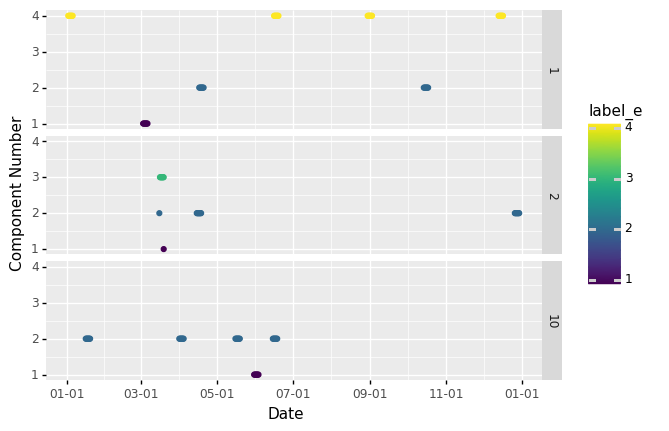

<ggplot: (8732277940758)>

In [191]:
plt_dta = (labeled_features.filter(labeled_features.label_e > 0)
           .where(col("machineID").isin({"1", "2","10"}))
           .select(labeled_features.machineID, labeled_features.dt_truncated, labeled_features.label_e)
           .toPandas())

plt_dta['dt_truncated'] = pd.to_datetime(plt_dta['dt_truncated'], format="%Y-%m-%d %H:%M:%S")
plt_dta.label_e = plt_dta.label_e.astype(int)

ggplot(aes(x="dt_truncated", y="label_e", color="label_e"), plt_dta) +\
    geom_point() +\
    xlab("Date") + ylab("Component Number") +\
    scale_x_date(date_labels = "%m-%d") +\
    facet_grid("machineID ~ .")
  

여기서 대부분의 날짜가 정상으로 표시되어 있음을 확인할 수 있습니다. 3개의 장비에는 시간에 따라 여러 오류가 발생합니다. 레이블이 지정된 각 결함에는 결함 날짜와 이전 7일이 포함되며 모두 실패한 부품을 나타내는 숫자로 표시됩니다.

모델의 목표는 오류가 발생하는 시기와 동시에 어떤 부품이 실패할지 예측하는 것입니다.

In [192]:
# 라벨링된 데이터를 S3에 저장합니다. 
prefix = 'train'


labeled_features.toPandas().to_csv(f"s3://{bucket}/{prefix}/train.csv",index=False)
               

# 추가 피처 (Optional)

### 에러 피처 (Errors features)
시계열 데이터와 마찬가지로 오류 데이터는 타임스탬프를 가지고 있습니다. 차이점은 오류 ID가 범주형 값이므로 시간 간격에 대해 평균을 내서는 안된다는 점입니다. 대신 시간 간격 내에서 발생한 각 유형의 오류 수를 계산합니다.

In [134]:

error_ind = (errors.groupBy("machineID","datetime","errorID").pivot('errorID')
             .agg(F.count('machineID').alias('dummy')).drop('errorID').fillna(0)
             .groupBy("machineID","datetime")
             .agg(F.sum('error1').alias('error1sum'), 
                  F.sum('error2').alias('error2sum'), 
                  F.sum('error3').alias('error3sum'), 
                  F.sum('error4').alias('error4sum'), 
                  F.sum('error5').alias('error5sum')))

error_count = (telemetry.join(error_ind, 
                              ((telemetry['machineID'] == error_ind['machineID']) 
                               & (telemetry['datetime'] == error_ind['datetime'])), "left")
               .drop('volt', 'rotate', 'pressure', 'vibration')
               .drop(error_ind.machineID).drop(error_ind.datetime)
               .fillna(0))

error_features = ['error1sum','error2sum', 'error3sum', 'error4sum', 'error5sum']

wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-24, 0)
for col_name in error_features:
    # We're only interested in the erros in the previous 24 hours.
    error_count = error_count.withColumn(col_name+'_rollingmean_24', 
                                         F.avg(col(col_name)).over(wSpec))

error_feat = (error_count.withColumn("dt_truncated", dt_truncated)
              .drop('error1sum', 'error2sum', 'error3sum', 'error4sum', 'error5sum').fillna(0)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean('error1sum_rollingmean_24').alias('error1sum_rollingmean_24'), 
                   F.mean('error2sum_rollingmean_24').alias('error2sum_rollingmean_24'), 
                   F.mean('error3sum_rollingmean_24').alias('error3sum_rollingmean_24'), 
                   F.mean('error4sum_rollingmean_24').alias('error4sum_rollingmean_24'), 
                   F.mean('error5sum_rollingmean_24').alias('error5sum_rollingmean_24')))

print(error_feat.count())
error_feat.limit(10).toPandas().head(10)

73100


,machineID,dt_truncated,error1sum_rollingmean_24,error2sum_rollingmean_24,error3sum_rollingmean_24,error4sum_rollingmean_24,error5sum_rollingmean_24
0,26,2015-04-27 12:00:00,0.0,0.0,0.0,0.0,0.0
1,26,2015-06-28 12:00:00,0.0,0.0,0.0,0.0,0.0
2,26,2015-08-11 00:00:00,0.0,0.0,0.0,0.0,0.0
3,29,2015-03-04 00:00:00,0.0,0.0,0.0,0.0,0.0
4,29,2015-04-06 00:00:00,0.0,0.0,0.0,0.0,0.0
5,29,2015-05-14 12:00:00,0.0,0.0,0.0,0.0,0.0
6,29,2015-06-20 12:00:00,0.0,0.0,0.0,0.0,0.0
7,29,2015-10-16 00:00:00,0.0,0.0,0.0,0.0,0.0
8,65,2015-04-17 12:00:00,0.0,0.0,0.0,0.0,0.0
9,65,2015-05-06 00:00:00,0.0,0.0,0.0,0.0,0.0


### 점검으로 마지막 교체 이후의 일 수
점검과 관련된 데이터를 활용하는 것은 중요한 부분입니다. 여기서 활용 가능한 부분은 시간 경과에 따라 각 부품의 교체 횟수 또는 부품이 교체된 후 경과된 시간을 계산하는 것입니다. 왜냐하면 부품을 오래 사용할수록 더 많은 성능 저하가 예상될 수 있기 때문입니다. 

In [135]:
# 각 부품 교체와 관련된 열을 생성합니다. 
maint_replace = (maint.groupBy("machineID","datetime","comp").pivot('comp')
                 .agg(F.count('machineID').alias('dummy')).fillna(0)
                 .groupBy("machineID","datetime")
                 .agg(F.sum('comp1').alias('comp1sum'), 
                      F.sum('comp2').alias('comp2sum'), 
                      F.sum('comp3').alias('comp3sum'),
                      F.sum('comp4').alias('comp4sum')))

maint_replace = maint_replace.withColumnRenamed('datetime','datetime_maint')

print(maint_replace.count())
maint_replace.limit(10).toPandas().head(10)

2528


,machineID,datetime_maint,comp1sum,comp2sum,comp3sum,comp4sum
0,75,2015-01-22 06:00:00,1,1,0,0
1,78,2015-08-19 06:00:00,1,0,0,0
2,11,2014-07-16 06:00:00,1,0,1,0
3,42,2015-09-18 06:00:00,0,0,1,1
4,84,2015-02-04 06:00:00,0,1,1,0
5,26,2015-05-06 06:00:00,0,1,0,1
6,79,2015-03-03 06:00:00,0,1,0,0
7,91,2015-02-16 06:00:00,1,0,1,0
8,32,2015-04-10 06:00:00,1,0,0,1
9,19,2015-05-13 06:00:00,1,1,0,0


교체와 관련된 피처는 부품의 변경 시점의 간격을 계산함으로써 추가될 수 있습니다. 이는 각각의 부품에 대해 변경 시점의 간격을 구하고 하나의 점검 테이블로 합칠 예정입니다.

부품1(comp1):

In [136]:
# 부품에 대한 정보를 시계열 피처의 timestamp에 맞출 것입니다.
telemetry_times = (telemetry_feat.select(telemetry_feat.machineID, telemetry_feat.dt_truncated)
                   .withColumnRenamed('dt_truncated','datetime_tel'))

# 각 부품에 대한 레코드
maint_comp1 = (maint_replace.where(col("comp1sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp2sum', 'comp3sum', 'comp4sum'))
maint_comp2 = (maint_replace.where(col("comp2sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp1sum', 'comp3sum', 'comp4sum'))
maint_comp3 = (maint_replace.where(col("comp3sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp1sum', 'comp2sum', 'comp4sum'))
maint_comp4 = (maint_replace.where(col("comp4sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp1sum', 'comp2sum', 'comp3sum'))


# 각각의 장비에 대해서 마지막 교체 날짜를 찾습니다.
maint_tel_comp1 = (telemetry_times.join(maint_comp1, 
                                        ((telemetry_times ['machineID']== maint_comp1['machineID']) 
                                         & (telemetry_times ['datetime_tel'] > maint_comp1['datetime_maint']) 
                                         & ( maint_comp1['comp1sum'] == '1')))
                   .drop(maint_comp1.machineID))
maint_tel_comp2 = (telemetry_times.join(maint_comp2, 
                                        ((telemetry_times ['machineID']== maint_comp2['machineID']) 
                                         & (telemetry_times ['datetime_tel'] > maint_comp2['datetime_maint']) 
                                         & ( maint_comp2['comp2sum'] == '1')))
                   .drop(maint_comp2.machineID))
maint_tel_comp3 = (telemetry_times.join(maint_comp3, ((telemetry_times ['machineID']==maint_comp3['machineID']) 
                                                      & (telemetry_times ['datetime_tel'] > maint_comp3['datetime_maint']) 
                                                      & ( maint_comp3['comp3sum'] == '1')))
                   .drop(maint_comp3.machineID))
maint_tel_comp4 = (telemetry_times.join(maint_comp4, ((telemetry_times['machineID']==maint_comp4['machineID']) 
                                                     & (telemetry_times['datetime_tel'] > maint_comp4['datetime_maint']) 
                                                     & (maint_comp4['comp4sum'] == '1')))
                   .drop(maint_comp4.machineID))


# 각각의 교체 사이의 기간을 계산합니다.
comp1 = (maint_tel_comp1.withColumn("sincelastcomp1", 
                                    datediff(maint_tel_comp1.datetime_tel, maint_tel_comp1.datetime_maint))
         .drop(maint_tel_comp1.datetime_maint).drop(maint_tel_comp1.comp1sum))
comp2 = (maint_tel_comp2.withColumn("sincelastcomp2", 
                                    datediff(maint_tel_comp2.datetime_tel, maint_tel_comp2.datetime_maint))
         .drop(maint_tel_comp2.datetime_maint).drop(maint_tel_comp2.comp2sum))
comp3 = (maint_tel_comp3.withColumn("sincelastcomp3", 
                                    datediff(maint_tel_comp3.datetime_tel, maint_tel_comp3.datetime_maint))
         .drop(maint_tel_comp3.datetime_maint).drop(maint_tel_comp3.comp3sum))
comp4 = (maint_tel_comp4.withColumn("sincelastcomp4", 
                                    datediff(maint_tel_comp4.datetime_tel, maint_tel_comp4.datetime_maint))
         .drop(maint_tel_comp4.datetime_maint).drop(maint_tel_comp4.comp4sum))

print(comp1.count())
print(comp2.count())
print(comp3.count())
print(com)


326094


,machineID,datetime_tel,sincelastcomp1
0,3,2015-01-01 12:00:00,139
1,3,2015-01-02 00:00:00,140
2,3,2015-01-02 12:00:00,140
3,3,2015-01-03 00:00:00,141
4,3,2015-01-03 12:00:00,141
5,3,2015-01-04 00:00:00,142
6,3,2015-01-04 12:00:00,142
7,3,2015-01-05 00:00:00,143
8,3,2015-01-05 12:00:00,143
9,3,2015-01-06 00:00:00,144


이제 테이블을 모두 합치고 12시간 시간 간격으로 데이터를 정렬합니다.

In [139]:
# 부품 3, 4번 테이블을 합칩니다.
comp3_4 = (comp3.join(comp4, ((comp3['machineID'] == comp4['machineID']) 
                              & (comp3['datetime_tel'] == comp4['datetime_tel'])), "left")
           .drop(comp4.machineID).drop(comp4.datetime_tel))

# 부품 2, 3, 4번 테이블을 합칩니다.
comp2_3_4 = (comp2.join(comp3_4, ((comp2['machineID'] == comp3_4['machineID']) 
                                  & (comp2['datetime_tel'] == comp3_4['datetime_tel'])), "left")
             .drop(comp3_4.machineID).drop(comp3_4.datetime_tel))

# 부품 1, 2, 3, 4번 테이블을 합칩니다.
comps_feat = (comp1.join(comp2_3_4, ((comp1['machineID'] == comp2_3_4['machineID']) 
                                      & (comp1['datetime_tel'] == comp2_3_4['datetime_tel'])), "left")
               .drop(comp2_3_4.machineID).drop(comp2_3_4.datetime_tel)
               .groupBy("machineID", "datetime_tel")
               .agg(F.max('sincelastcomp1').alias('sincelastcomp1'), 
                    F.max('sincelastcomp2').alias('sincelastcomp2'), 
                    F.max('sincelastcomp3').alias('sincelastcomp3'), 
                    F.max('sincelastcomp4').alias('sincelastcomp4'))
               .fillna(0))

# time_val 시간으로 데이터를 정렬합니다.
dt_truncated = ((round(unix_timestamp(col("datetime_tel")) / time_val) * time_val).cast("timestamp"))

# Collect data
maint_feat = (comps_feat.withColumn("dt_truncated", dt_truncated)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean('sincelastcomp1').alias('comp1sum'), 
                   F.mean('sincelastcomp2').alias('comp2sum'), 
                   F.mean('sincelastcomp3').alias('comp3sum'), 
                   F.mean('sincelastcomp4').alias('comp4sum')))

print(maint_feat.count())
maint_feat.limit(10).toPandas().head(10)

73100


,machineID,dt_truncated,comp1sum,comp2sum,comp3sum,comp4sum
0,1,2015-04-02 12:00:00,110.0,305.0,245.0,260.0
1,1,2015-05-12 00:00:00,150.0,345.0,285.0,300.0
2,1,2015-07-26 12:00:00,225.0,420.0,360.0,375.0
3,1,2015-08-04 00:00:00,234.0,429.0,369.0,384.0
4,1,2015-08-23 12:00:00,253.0,448.0,388.0,403.0
5,1,2015-12-17 00:00:00,369.0,564.0,504.0,519.0
6,2,2015-05-31 00:00:00,349.0,289.0,319.0,184.0
7,2,2015-08-23 00:00:00,433.0,373.0,403.0,268.0
8,2,2015-09-14 12:00:00,455.0,395.0,425.0,290.0
9,3,2015-02-17 12:00:00,186.0,81.0,246.0,231.0


### 장비 피처
